In [1]:
# Importing usefull libraries

import torch
import torch.nn.functional as F # For functional neural network
import numpy as np # For numerical computations
import matplotlib.pyplot as plt # For visualization

# For loading and transforming the data

from torchvision import datasets, transforms 
from torch import nn, optim

In [2]:
#  A helper function for checking the prediction using graphs

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [28]:
# Define a transform to normalize the hand written digits data

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

# Download and load the training data

trainset = datasets.MNIST('MNIST_data/',
                          download=True,
                          train=True,
                          transform = transform
                          )
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 64,
                                          shuffle=True)


In [17]:
# Download and load the training data for the fashion data

trainset = datasets.FashionMNIST('Fasion_data/',
                                 download=True,
                                 train=True,
                                 transform = transform
                                 )
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 64, 
                                          shuffle=True
                                          )

# Download and load the test data for the fashion data

testset= datasets.FashionMNIST('Fasion_data/',
                               download=True,
                               train=False,
                               transform = transform
                               )
testloader= torch.utils.data.DataLoader(testset,
                                        batch_size = 64, 
                                        shuffle=True
                                        )

In [31]:
# Lets check the size and type of the data we downloaded

images,labels = next(iter(trainloader))
print(type(images))
print(images.shape)
print(labels.shape)
print(labels)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([2, 8, 7, 6, 1, 9, 7, 6, 0, 2, 8, 4, 5, 4, 7, 7, 5, 0, 5, 2, 4, 4, 0, 6,
        9, 7, 8, 1, 6, 2, 3, 3, 3, 7, 0, 6, 4, 8, 3, 6, 1, 6, 0, 7, 5, 7, 8, 8,
        6, 3, 1, 1, 6, 1, 5, 7, 1, 5, 7, 0, 0, 2, 1, 2])


The label is 8


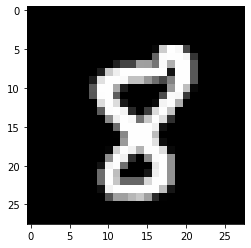

In [32]:
# Lets check out a single image and its label

plt.imshow(images[1].numpy().squeeze(),cmap='Greys_r')
print(f'The label is {labels[1].numpy()}')

In [33]:
# Training a model for classifiying hand written digits 

# Lets train a network of 2 hidden layers with each being Relu activated

hand_written_model = nn.Sequential(nn.Linear(784,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss() # Negative Log Likelihood loss

# Lets use an optimizer with a Stochastic Gradient Decent of learning rate 0.003

optimizer = optim.SGD(hand_written_model.parameters(),lr=0.003) 

epochs = 5

for epoch in range(epochs):

  # Initializing the running loss for later averaging
  running_loss = 0.0

  for images,labels in trainloader:

    # Lets flatten the image to fit into the network layer
    # .view will change our [64,1,28,28] to [64,784] i.e 28*28*1=784
    
    images = images.view(images.shape[0],-1)

    optimizer.zero_grad()

    output = hand_written_model.forward(images)

    loss = criterion(output,labels)

    loss.backward()

    running_loss += loss.item()

    optimizer.step()

  print(f'Training loss: {running_loss/len(trainloader)}')


Training loss: 1.8479479027709473
Training loss: 0.8185606790122701
Training loss: 0.5224122261441847
Training loss: 0.4295903445878771
Training loss: 0.3849476414925254


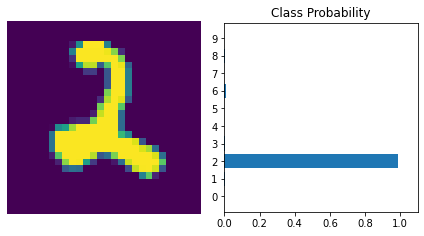

In [40]:
# Testing the hand written classifier model

images,labels = next(iter(trainloader))

img = images[0].view(1,-1)

with torch.no_grad():
  logits = hand_written_model.forward(img)

# Changing the probabilities from our nn output into positive number and 
# finding the displaying the result using our helper function

ps = torch.exp(logits)

view_classify(img,ps,version='MNIST')

In [26]:
# Training a model for classifiying fasion-MNIST data set

''' 

Here we have 3 hidden layers each having a drop out of 20% 
 We added drop out for the purpose of decreasing overfitting
 We will eliminate all the dropouts for evaluation and get the back while 
training 

'''
model = nn.Sequential(nn.Linear(784,256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256,128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss(reduction='sum')

optimizer = optim.Adam(model.parameters(),lr=0.003)

epochs = 30

train_losses = []
test_losses = []

for epoch in range(epochs):

  total_training_loss = 0.0

  for images,labels in trainloader:

    images = images.view(images.shape[0],-1)

    optimizer.zero_grad()

    output = model.forward(images)

    loss = criterion(output,labels)

    total_training_loss += loss.item()

    loss.backward()

    optimizer.step()

   
    
  total_test_loss = 0.0
  total_correct = 0.0

  with torch.no_grad():

    # Here we used model.eval() to remove the dropouts for testing our model
    
    model.eval()
    for images,labels in testloader:

      images = images.view(images.shape[0],-1)

      logps = model(images)
      test_loss = criterion(logps,labels)

      total_test_loss += test_loss.item()

      ps_fashion = torch.exp(logps)

      top_p,top_class = ps_fashion.topk(1,dim=1)

      equals = top_class == labels.view(*top_class.shape)
    
      total_correct += equals.sum().item()
  
  # Here we get the dropouts back to the model by using model.train()
  
  model.train()
  train_loss = total_training_loss / len(trainloader.dataset)
  test_loss = total_test_loss / len(testloader.dataset)
  accuracy = total_correct / len(testloader.dataset)

  train_losses.append(train_loss) 
  test_losses.append(test_loss)

  print('==========================')
  print(f'Epoch {epoch}')
  print(f'Training loss: {train_loss}')
  print(f'Test loss: {test_loss}')
  print(f'Test accuracy: {accuracy*100}')
  print('==========================')

Epoch 0
Training loss: 0.6069811887741089
Test loss: 0.49761438035964967
Test accuracy: 81.91000000000001
Epoch 1
Training loss: 0.4825502340157827
Test loss: 0.4280258972167969
Test accuracy: 84.92
Epoch 2
Training loss: 0.4501264285723368
Test loss: 0.4220623287677765
Test accuracy: 84.8
Epoch 3
Training loss: 0.43103395976225534
Test loss: 0.42362824950218203
Test accuracy: 85.09
Epoch 4
Training loss: 0.41853837067286176
Test loss: 0.40511627292633057
Test accuracy: 85.81
Epoch 5
Training loss: 0.4110726539770762
Test loss: 0.38959638419151305
Test accuracy: 86.21
Epoch 6
Training loss: 0.40291477995713554
Test loss: 0.377946484041214
Test accuracy: 86.50999999999999
Epoch 7
Training loss: 0.40233449681599937
Test loss: 0.39297593989372254
Test accuracy: 85.68
Epoch 8
Training loss: 0.39797556784947713
Test loss: 0.3850397620201111
Test accuracy: 86.06
Epoch 9
Training loss: 0.38909111011823017
Test loss: 0.38659927418231965
Test accuracy: 86.72999999999999
Epoch 10
Training loss: 

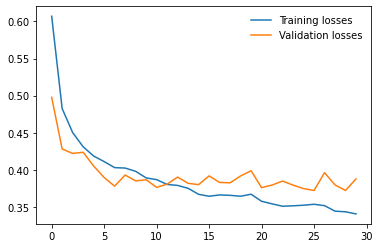

In [41]:
# Plot the graph of training and validation loss to see the overfitting effect

plt.plot(train_losses,label='Training losses')
plt.plot(test_losses,label='Validation losses')
plt.legend(frameon=False)
plt.show()

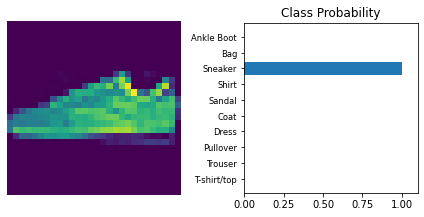

In [42]:
# Testing the fasion classifier model

fashion_images,labels = next(iter(testloader))

img = fashion_images[0].view(1,-1)

with torch.no_grad():
  logits = model.forward(img)

ps = F.softmax(logits,dim=1)

view_classify(img,ps,version='Fashion')